In [9]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import warnings
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
warnings.filterwarnings('ignore')

TODAY = pd.Timestamp.today()

df = pd.read_csv('C:\\Users\\bista\\Documents\\Downloads\\DataWave_Music_Sprint_Dataset.csv')
print(df.head())
print("Loaded CSV.")


# === DEFINE OUTPUT DIRECTORY ===
OUTPUT_DIR = Path("C:/Users/bista/Documents/Downloads/cleaned_data")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)



  user_id  country  age gender subscription_type  \
0   U1403    Nepal   23      F            Premum   
1   U1165    Nepal   63   male           Student   
2   U1474      USA   45      F            Premum   
3   U1478  Nigeria   16      F            Family   
4   U1609    Ghana   29      M              Free   

   avg_listening_hours_per_week  total_songs_played skip_rate  \
0                          11.5                 510        5%   
1                          11.3                 526        5%   
2                           2.0                 476       30%   
3                          12.1                 529       20%   
4                           6.4                 477       0.2   

   satisfaction_score churned monthly_fee   join_date  
0                 2.0       0        7.99  03/21/2024  
1                 3.0       0           0  08/10/2023  
2                 3.0       0        7.99  04/05/2022  
3                 5.0     yes       12.99  12/16/2023  
4               

In [26]:
# Standardise column names and common Rename 

df.columns = (
    df.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_")
)
col_map = {
    'avg_listening_hours_per_week': 'avg_listening_per_Week',
    'hours_listed': 'total_listening_hours_per_week',
    'join_date': 'join_date',
    'dateJoined': 'join_date',
    'last_active_date': 'last_active',
    'churn':'churned',
    'churned':'churned'
}
df.rename(columns=col_map, inplace=True)

# Ensure columns exist
for c in ['subscription_type','gender','country']:
    if c not in df.columns:
        df[c] = 'unknown'

# === STRING CLEANING: subscription_type, gender, country ===
df['subscription_type'] = df['subscription_type'].astype(str).str.strip().str.lower()
subs_fix = {
    'premum': 'premium', 'premiun': 'premium', 'prem': 'premium',
    'premu m': 'premium', 'premium ': 'premium',
    'fam': 'family', 'family ': 'family',
    'studnt': 'student', 'student ': 'student'
}
df['subscription_type'] = df['subscription_type'].replace(subs_fix).fillna('unknown')

df['gender'] = df['gender'].astype(str).str.strip().str.lower().replace({'f':'female','m':'male','nan':'unknown','': 'unknown'}).fillna('unknown')
df['country'] = df['country'].astype(str).str.strip().replace({'': 'Unknown', 'nan':'Unknown'}).fillna('Unknown').str.title()

num_map = {
    'age': 'age',
    'avg_listening_hours_per_week': 'avg_listening_hours_per_week',
    'total_songs_played': 'total_songs_played',
    'satisfaction_score': 'satisfaction_score',
    'monthly_fee': 'monthly_fee'
}

for col in num_map:
    if col in df.columns:
        # Include replacement for 'USD' and commas
        df[col] = pd.to_numeric(
            df[col].astype(str).str.replace('USD', '', regex=False).str.replace(',', '').str.strip(),
            errors='coerce'
        )

In [21]:
# === SKIP RATE PARSING ===
if 'skip_rate' in df.columns:
    def parse_skip(x):
        if pd.isna(x):
            return np.nan
        s = str(x).strip()
        # Remove percent sign
        if s.endswith('%'):
            s2 = s[:-1].strip()
            try:
                return float(s2)
            except:
                return np.nan
        # if decimal between 0 and 1 treat as fraction -> percent
        try:
            v = float(s)
            if 0 <= v <= 1:
                return v * 100.0
            return v
        except:
            return np.nan
    df['skip_rate_pct'] = df['skip_rate'].apply(parse_skip)
else:
    df['skip_rate_pct'] = np.nan

# If skip_rate_pct entirely missing, create column and fill later
df['skip_rate_pct'] = pd.to_numeric(df['skip_rate_pct'], errors='coerce')

In [22]:
# === CHURN CONVERSION ===
if 'churned' in df.columns:
    df['churned'] = df['churned'].astype(str).str.lower().str.strip()
    df['churned'] = df['churned'].replace({'yes':1, 'no':0, 'true':1, 'false':0, '1':1, '0':0})
    df['churned'] = pd.to_numeric(df['churned'], errors='coerce')
    df['churned'] = df['churned'].fillna(0).astype(int)
else:
    df['churned'] = 0

In [23]:
# === DATES: join_date and tenure ===

TODAY = pd.Timestamp.today()

if 'join_date' in df.columns:
    # try parse with default (month-first) then fallback to day-first for unparsed strings
    df['join_date_parsed'] = pd.to_datetime(df['join_date'], errors='coerce', dayfirst=False)
    mask_na = df['join_date_parsed'].isna() & df['join_date'].notna()
    if mask_na.any():
        try:
            df.loc[mask_na, 'join_date_parsed'] = pd.to_datetime(df.loc[mask_na, 'join_date'], errors='coerce', dayfirst=True)
        except Exception:
            pass
    df['join_date'] = df['join_date_parsed']
    df.drop(columns=['join_date_parsed'], inplace=True)
else:
    df['join_date'] = pd.NaT

df['tenure_days'] = (TODAY - df['join_date']).dt.days
# keep tenure_days numeric (NaN where join_date missing)
# === DUPLICATES: user_id ===
if 'user_id' in df.columns:
    dup_count = df['user_id'].duplicated().sum()
    print("Duplicate user_id count:", dup_count)
    if dup_count > 0:
        df = df.drop_duplicates(subset=['user_id'], keep='first')


Duplicate user_id count: 14


In [24]:
# Fill categorical with 'unknown'
df['subscription_type'] = df['subscription_type'].fillna('unknown')
df['gender'] = df['gender'].fillna('unknown')
df['country'] = df['country'].fillna('Unknown')

df['monthly_fee'] = df['monthly_fee'].fillna(0.0)

# Fill numeric with medians (if median NaN -> 0)
numeric_fill_cols = [
    'age','avg_listening_hours_per_week','total_songs_played',
    'satisfaction_score','monthly_fee','skip_rate_pct','tenure_days'
]
for c in numeric_fill_cols:
    if c in df.columns:
        med = df[c].median()
        if pd.isna(med):
            med = 0.0
        df[c] = df[c].fillna(med)


In [16]:
# === REMOVE UNREALISTIC OUTLIERS ===
if 'age' in df.columns:
    df = df[(df['age'] >= 10) & (df['age'] <= 90)]
if 'avg_listening_hours_per_week' in df.columns:
    df = df[(df['avg_listening_hours_per_week'] >= 0) & (df['avg_listening_hours_per_week'] <= 200)]

print("Shape after cleaning:", df.shape)

# === FINAL SUBSCRIPTION NORMALIZATION ===
df['subscription_type'] = df['subscription_type'].replace({
    'fam': 'family', 'family ': 'family', 'studnt': 'student', 'student ': 'student'
}).str.lower()

Shape after cleaning: (691, 14)


In [28]:
# === SAVE CLEANED CSV ===
clean_path = OUTPUT_DIR / "datawave_music_cleaned_full.csv"
df.to_csv(clean_path, index=False)

print("Saved cleaned CSV to:", clean_path)


Saved cleaned CSV to: C:\Users\bista\Documents\Downloads\cleaned_data\datawave_music_cleaned_full.csv


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

# --- Load raw data ---
file = r'C:\\Users\\bista\\Documents\\Downloads\\DataWave_Music_Sprint_Dataset.csv'
df = pd.read_csv(file)

# ===============================
# 1️⃣ Clean user_id
# ===============================
df = df.drop_duplicates(subset=['user_id'])
df = df.dropna(subset=['user_id'])

# ===============================
# 2️⃣ Clean gender
# ===============================
df = df.dropna(subset=['gender'])
df['gender'] = df['gender'].astype(str).str.lower().str.strip()
gender_map = {'f':'Female','female':'Female','m':'Male','male':'Male','other':'Other'}
df['gender'] = df['gender'].map(gender_map)

# ===============================
# 3️⃣ Clean country
# ===============================
df['country'] = df['country'].astype(str).str.lower().str.strip().str.replace('.', '', regex=False)
country_map = {'uk':'United Kingdom','united kingdom':'United Kingdom','usa':'United States','ind':'India'}
df['country'] = df['country'].map(country_map).fillna(df['country'])
df['country'] = df['country'].str.title()

# ===============================
# 4️⃣ Clean subscription_type
# ===============================
df['subscription_type'] = df['subscription_type'].astype(str).str.lower().str.strip()
subscription_map = {'studnt':'Student','fam':'Family','premum':'Premium'}
df['subscription_type'] = df['subscription_type'].map(subscription_map).fillna(df['subscription_type'])
df['subscription_type'] = df['subscription_type'].str.title()

# ===============================
# 5️⃣ Clean satisfaction_score & skip_rate
# ===============================
df = df.dropna(subset=['satisfaction_score'])

def clean_skip_rate(x):
    x = str(x).strip().lower()
    if "%" in x:
        x = x.replace("%","")
        return pd.to_numeric(x, errors="coerce")/100
    num = pd.to_numeric(x, errors="coerce")
    if pd.notna(num):
        return num
    words = {"zero":0,"one":1,"two":2,"three":3,"four":4,"five":5,"six":6,"seven":7,"eight":8,"nine":9,"ten":10}
    return words.get(x,np.nan)

df['skip_rate'] = df['skip_rate'].apply(clean_skip_rate)
df['skip_rate'] = df['skip_rate'].apply(lambda x: x/100 if pd.notna(x) and x>1 else x)

# ===============================
# 6️⃣ Standardize churned
# ===============================
df['churned'] = df['churned'].astype(str).str.strip().str.lower()
df['churned'] = df['churned'].replace({'1':'yes','0':'no','yes':'yes','no':'no','true':'yes','false':'no'})

# ===============================
# 7️⃣ Clean monthly_fee
# ===============================
def clean_monthly_fee(x):
    if pd.isna(x): return np.nan
    x = str(x).strip().lower().replace("usd","").replace("$","")
    num = pd.to_numeric(x, errors='coerce')
    if pd.notna(num): return num
    if x in ["free","none","no fee"]: return 0.0
    return np.nan

df['monthly_fee_clean'] = df['monthly_fee'].apply(clean_monthly_fee)

# ===============================
# 8️⃣ Clean join_date
# ===============================
def clean_date(x):
    if pd.isna(x): return pd.NaT
    x = str(x).strip().replace('-','/')
    parts = x.split('/')
    try:
        day, month = int(parts[0]), int(parts[1])
    except:
        return pd.NaT
    try:
        if day>12: return pd.to_datetime(x, format='%d/%m/%Y', errors='coerce')
        if month>12: return pd.to_datetime(x, format='%m/%d/%Y', errors='coerce')
        return pd.to_datetime(x, dayfirst=True, errors='coerce')
    except:
        return pd.NaT

df['join_date'] = df['join_date'].apply(clean_date)

# ===============================
# 9️⃣ Convert age numeric & create age groups
# ===============================
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['age_group'] = pd.cut(df['age'], bins=[0,18,25,35,50,100],
                         labels=['<18','18–25','25–35','35–50','50+'])

# ===============================
# Check cleaned data
# ===============================
print(df.shape)
print(df['churned'].value_counts())
print(df['subscription_type'].value_counts())
print(df['country'].value_counts())
print(df['age_group'].value_counts(dropna=False))

# ===============================
# Save cleaned dataset
# ===============================
cleaned_file = r"C:\Users\bista\Documents\Downloads\cleaned.csv"
df.to_csv(cleaned_file, index=False)
print("Cleaned dataset saved at:", cleaned_file)


(572, 14)
churned
no     400
yes    172
Name: count, dtype: int64
subscription_type
Family     179
Student    165
Premium    150
Free        78
Name: count, dtype: int64
country
United Kingdom    153
India              91
United States      63
Kenya              56
Nigeria            53
Ghana              42
South Africa       41
Nepal              38
Brazil             35
Name: count, dtype: int64
age_group
35–50    173
50+      148
25–35    100
18–25     78
<18       73
Name: count, dtype: int64
Cleaned dataset saved at: C:\Users\bista\Documents\Downloads\cleaned.csv


In [19]:

df.columns, df['country'].unique()


(Index(['user_id', 'country', 'age', 'gender', 'subscription_type',
        'avg_listening_hours_per_week', 'total_songs_played', 'skip_rate',
        'satisfaction_score', 'churned', 'monthly_fee', 'join_date',
        'monthly_fee_clean', 'age_group'],
       dtype='object'),
 array(['Nepal', 'United States', 'Nigeria', 'Ghana', 'United Kingdom',
        'India', 'Kenya', 'Brazil', 'South Africa'], dtype=object))

<!-- 🎨 EXPLORATORY ANALYSIS & PLOTS -->

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='churned', y='skip_rate', palette='viridis')
plt.title("Skip Rate by Churn", fontsize=14)
plt.xlabel("Churned")
plt.ylabel("Skip Rate")

plt.show()


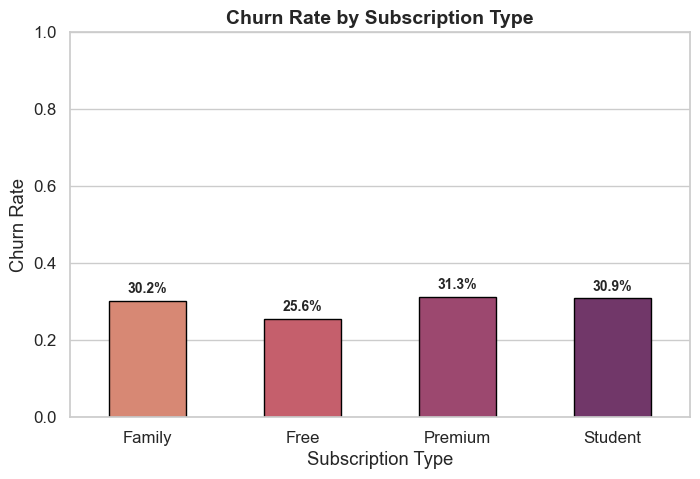

In [57]:
sub_churn = df.groupby('subscription_type')['churned']\
              .apply(lambda x: (x=='yes').mean())\
              .reset_index()

plt.figure(figsize=(8,5))
ax = sns.barplot(
    data=sub_churn,
    x='subscription_type',
    y='churned',
    palette='flare',
    width=0.5,  # thinner bars
    edgecolor='black'
)

plt.title("Churn Rate by Subscription Type", fontsize=14, weight='bold')
plt.xlabel("Subscription Type")
plt.ylabel("Churn Rate")
plt.ylim(0,1)

# Add % labels
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2,
        height + 0.02,  # slightly above the bar
        f"{height*100:.1f}%",  # convert to percentage
        ha='center',
        fontsize=10,
        weight='bold'
    )

plt.show()


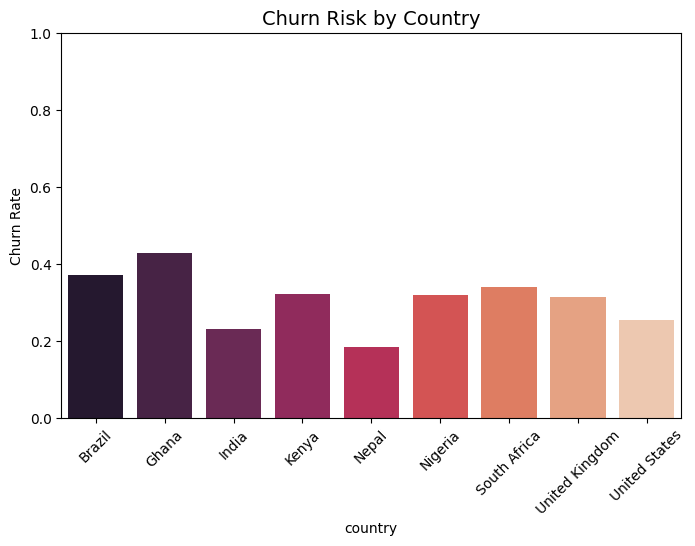

In [22]:
country_churn = df.groupby('country')['churned'].apply(lambda x: (x=='yes').mean()).reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=country_churn, x='country', y='churned', palette='rocket')
plt.title("Churn Risk by Country", fontsize=14)
plt.ylabel("Churn Rate")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()


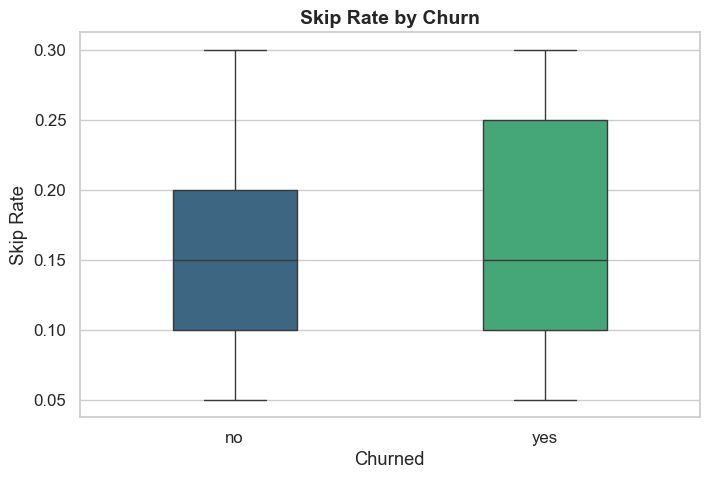

In [55]:
plt.figure(figsize=(8,5))

sns.boxplot(
    data=df,
    x='churned',
    y='skip_rate',
    palette='viridis',
    width=0.4  # make inner boxes narrower
)

plt.title("Skip Rate by Churn", fontsize=14, weight='bold')
plt.xlabel("Churned")
plt.ylabel("Skip Rate")
plt.show()


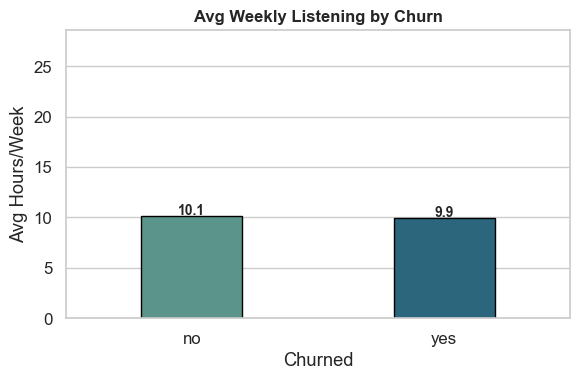

In [54]:
# Calculate mean listening per churn
listen_mean = df.groupby('churned')['avg_listening_hours_per_week'].mean().reset_index()

plt.figure(figsize=(6,4))  # keep figure normal

ax = sns.barplot(
    data=listen_mean,
    x='churned',
    y='avg_listening_hours_per_week',
    palette='crest',
    edgecolor='black',
    width=0.4  # smaller inner bars
)

# Styling
plt.title("Avg Weekly Listening by Churn", fontsize=12, weight='bold')
plt.xlabel("Churned")
plt.ylabel("Avg Hours/Week")
plt.ylim(0, df['avg_listening_hours_per_week'].max() + 5)

# Add mean value labels
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2,
        height + 0.2,
        f"{height:.1f}",
        ha='center',
        fontsize=10,
        weight='bold'
    )

plt.tight_layout()
plt.show()


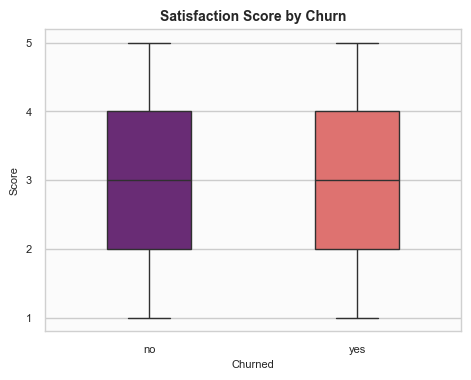

In [52]:
plt.figure(figsize=(5,4))  # smaller, truly compact

ax = sns.boxplot(
    data=df,
    x='churned',
    y='satisfaction_score',
    palette='magma',
    width=0.4  # narrower boxes
)

# ---- Styling ----
plt.title("Satisfaction Score by Churn", fontsize=10, weight='bold')
plt.xlabel("Churned", fontsize=8)
plt.ylabel("Score", fontsize=8)

# Light grey border (card-style)
for spine in ax.spines.values():
    spine.set_linewidth(1)
    spine.set_edgecolor("#d0d0d0")

ax.set_facecolor("#fbfbfb")  # soft card background
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()


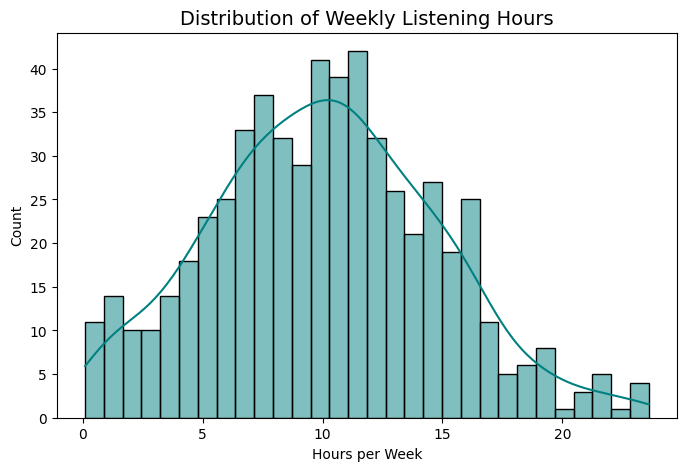

In [26]:
plt.figure(figsize=(8,5))
sns.histplot(df['avg_listening_hours_per_week'], kde=True, bins=30, color='teal')
plt.title("Distribution of Weekly Listening Hours", fontsize=14)
plt.xlabel("Hours per Week")
plt.ylabel("Count")
plt.show()


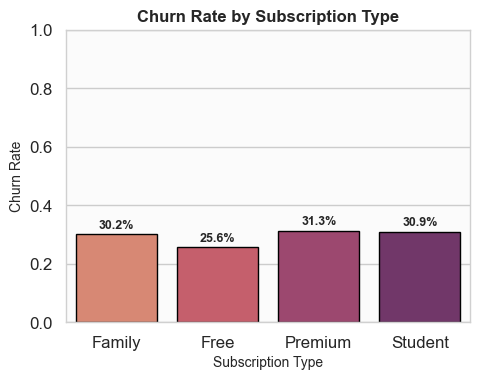

In [49]:
# Make sure churned is lowercase
df['churned'] = df['churned'].str.lower()  # 'yes'/'no'

# Compute churn rate
sub_churn = df.groupby('subscription_type')['churned']\
              .apply(lambda x: (x == 'yes').mean())\
              .reset_index()

plt.figure(figsize=(5,4))   # compact dashboard-style box

ax = sns.barplot(
    data=sub_churn,
    x='subscription_type',
    y='churned',
    palette='flare',
    edgecolor='black'
)

# ---- Styling for professional card look ----
plt.title("Churn Rate by Subscription Type", fontsize=12, weight='bold')
plt.xlabel("Subscription Type", fontsize=10)
plt.ylabel("Churn Rate", fontsize=10)
plt.ylim(0, 1)

# Light grey border (card box)
for spine in ax.spines.values():
    spine.set_linewidth(1)
    spine.set_edgecolor("#d0d0d0")

ax.set_facecolor("#fbfbfb")   # very soft card background

# Add % labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2,
        height + 0.02,
        f"{height*100:.1f}%",
        ha='center',
        fontsize=9,
        weight='bold'
    )

plt.tight_layout()
plt.show()


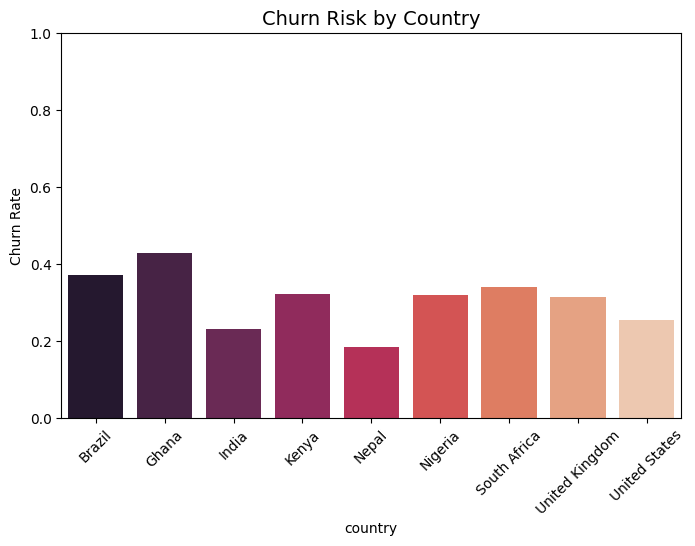

In [29]:
country_churn = df.groupby('country')['churned'].apply(lambda x: (x=='yes').mean()).reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=country_churn, x='country', y='churned', palette='rocket')
plt.title("Churn Risk by Country", fontsize=14)
plt.ylabel("Churn Rate")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()


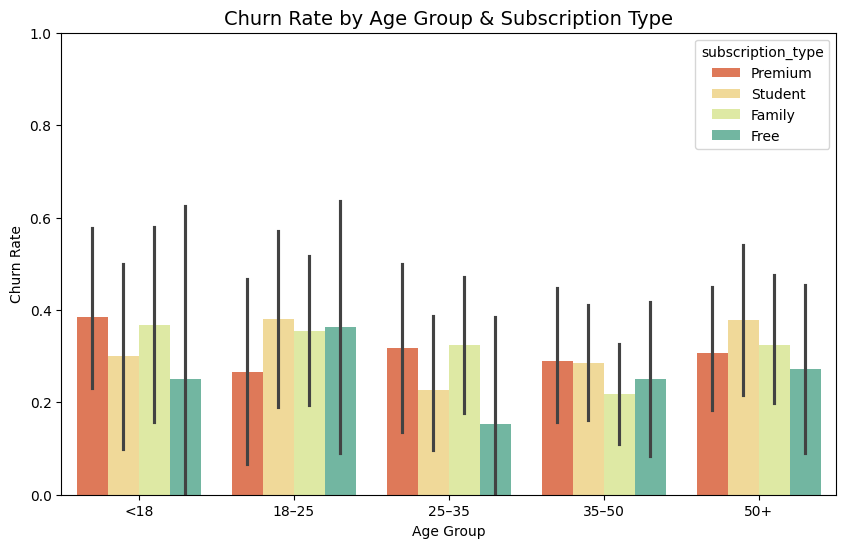

In [30]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df,
    x='age_group',
    y=(df['churned']=='yes').astype(int),
    hue='subscription_type',
    palette='Spectral'
)
plt.title("Churn Rate by Age Group & Subscription Type", fontsize=14)
plt.xlabel("Age Group")
plt.ylabel("Churn Rate")
plt.ylim(0,1)
plt.show()


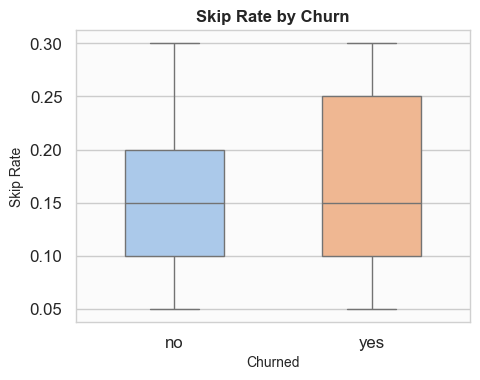

In [45]:
plt.figure(figsize=(5,4))   # small clean card-size chart

ax = sns.boxplot(
    x='churned',
    y='skip_rate',
    data=df,
    palette='pastel',
    width=0.5             # slimmer, modern box
)

# ---- Styling for premium dashboard look ----
plt.title("Skip Rate by Churn", fontsize=12, weight='bold')
plt.xlabel("Churned", fontsize=10)
plt.ylabel("Skip Rate", fontsize=10)

# Light grey border (card style)
for spine in ax.spines.values():
    spine.set_linewidth(1)
    spine.set_edgecolor("#d0d0d0")

# Very subtle background
ax.set_facecolor("#fbfbfb")

plt.tight_layout()
plt.show()


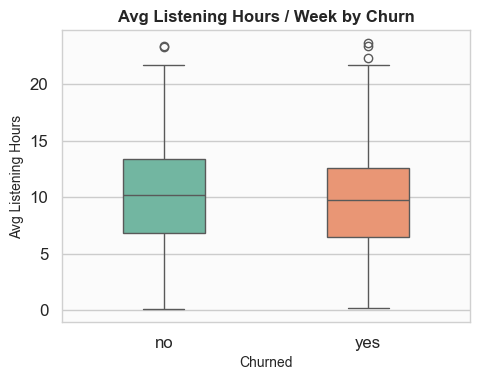

In [44]:
plt.figure(figsize=(5,4))   # ⭐ small card size

ax = sns.boxplot(
    x='churned',
    y='avg_listening_hours_per_week',
    data=df,
    palette='Set2',
    width=0.4            # ⭐ slim elegant box
)

# ---- Styling for dashboard feel ----
plt.title("Avg Listening Hours / Week by Churn", fontsize=12, weight='bold')
plt.xlabel("Churned", fontsize=10)
plt.ylabel("Avg Listening Hours", fontsize=10)

# Light grey card border
for spine in ax.spines.values():
    spine.set_linewidth(1)
    spine.set_edgecolor("#d0d0d0")

ax.set_facecolor("#fbfbfb")

plt.tight_layout()
plt.show()


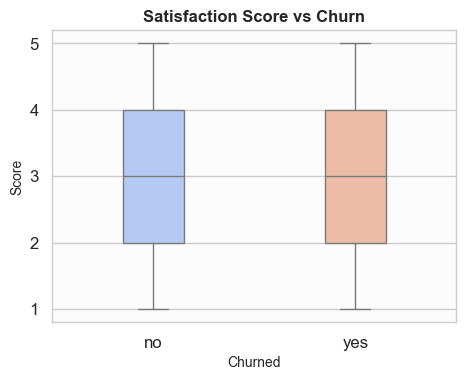

In [ ]:
# --- small card version ---
plt.figure(figsize=(5,4))  # ⭐ small “card box” size

ax = sns.boxplot(
    x='churned',
    y='satisfaction_score',
    data=df,
    palette='coolwarm',
    width=0.3
)

# --- Styling (dashboard look) ---
plt.title("Satisfaction Score vs Churn", fontsize=12, weight='bold')
plt.xlabel("Churned", fontsize=10)
plt.ylabel("Score", fontsize=10)

# subtle border
for spine in ax.spines.values():
    spine.set_linewidth(1)
    spine.set_edgecolor("#cccccc")

ax.set_facecolor("#fcfcfc")

plt.tight_layout()
plt.show()

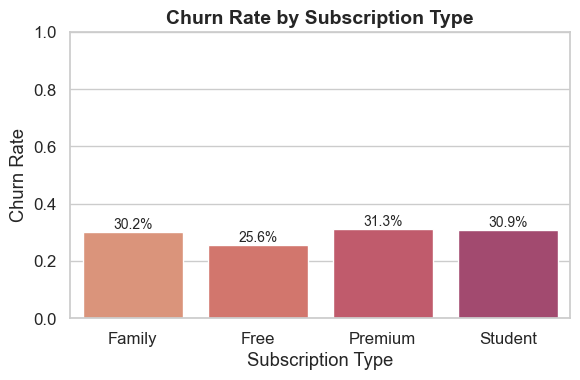

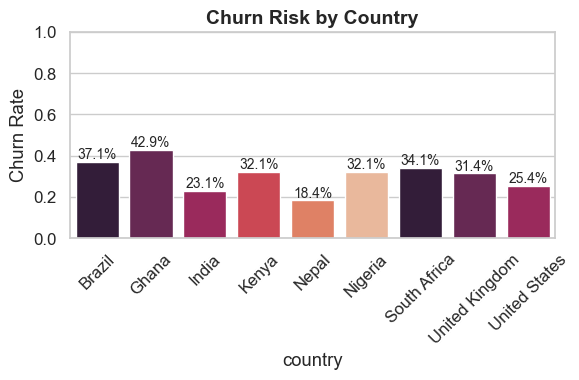

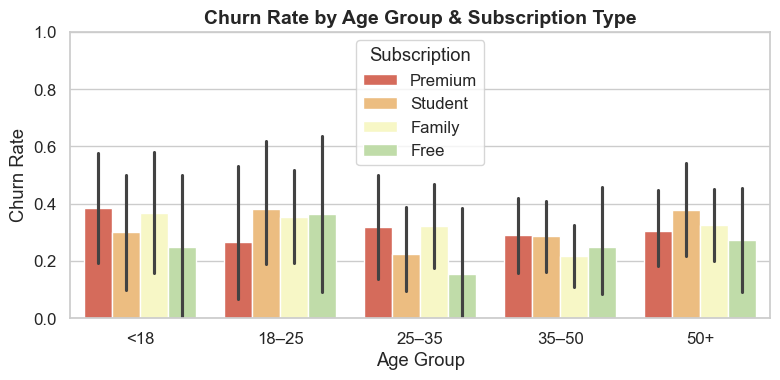

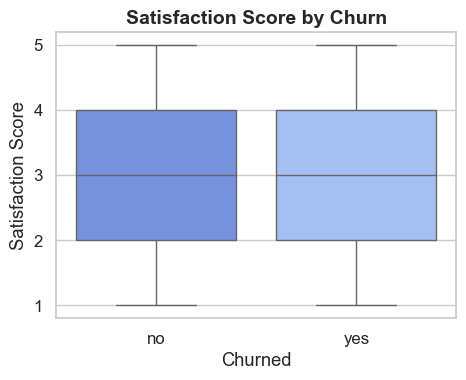

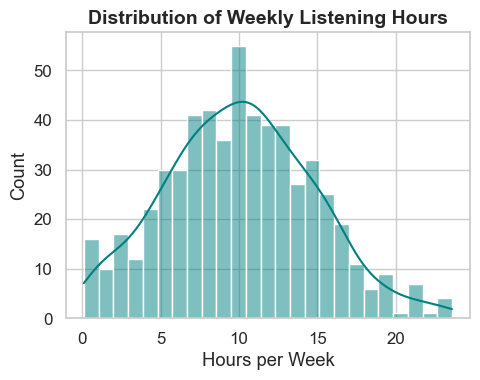

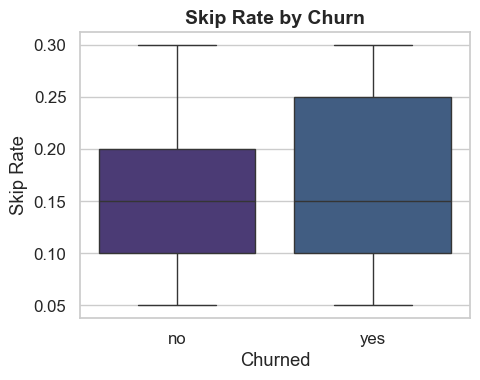

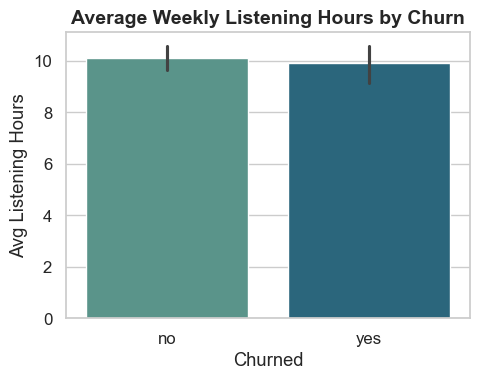

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set global aesthetics
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)
palette_bar = sns.color_palette("flare")
palette_country = sns.color_palette("rocket")
palette_age = sns.color_palette("Spectral", n_colors=5)
palette_box = sns.color_palette("coolwarm")
palette_skip = sns.color_palette("viridis")

# -----------------------------
# 1️⃣ Churn Rate by Subscription Type with percentage labels
# -----------------------------
sub_churn = df.groupby('subscription_type')['churned'].apply(lambda x: (x=='yes').mean()).reset_index()

plt.figure(figsize=(6,4))
ax = sns.barplot(data=sub_churn, x='subscription_type', y='churned', palette=palette_bar)
plt.title("Churn Rate by Subscription Type", fontsize=14, weight='bold')
plt.ylim(0,1)
plt.ylabel("Churn Rate")
plt.xlabel("Subscription Type")

# Add percentage labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height*100:.1f}%', (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# -----------------------------
# 2️⃣ Churn Risk by Country
# -----------------------------
country_churn = df.groupby('country')['churned'].apply(lambda x: (x=='yes').mean()).reset_index()

plt.figure(figsize=(6,4))
ax = sns.barplot(data=country_churn, x='country', y='churned', palette=palette_country)
plt.title("Churn Risk by Country", fontsize=14, weight='bold')
plt.ylim(0,1)
plt.ylabel("Churn Rate")
plt.xticks(rotation=45)

# Percentage labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height*100:.1f}%', (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# -----------------------------
# 3️⃣ Churn Rate by Age Group & Subscription Type
# -----------------------------
plt.figure(figsize=(8,4))
sns.barplot(
    data=df,
    x='age_group',
    y=(df['churned']=='yes').astype(int),
    hue='subscription_type',
    palette=palette_age
)
plt.title("Churn Rate by Age Group & Subscription Type", fontsize=14, weight='bold')
plt.xlabel("Age Group")
plt.ylabel("Churn Rate")
plt.ylim(0,1)
plt.legend(title='Subscription')
plt.tight_layout()
plt.show()

# -----------------------------
# 4️⃣ Satisfaction Score by Churn
# -----------------------------
plt.figure(figsize=(5,4))
sns.boxplot(x='churned', y='satisfaction_score', data=df, palette=palette_box)
plt.title("Satisfaction Score by Churn", fontsize=14, weight='bold')
plt.xlabel("Churned")
plt.ylabel("Satisfaction Score")
plt.tight_layout()
plt.show()

# -----------------------------
# 5️⃣ Distribution of Weekly Listening Hours
# -----------------------------
plt.figure(figsize=(5,4))
sns.histplot(df['avg_listening_hours_per_week'], kde=True, bins=25, color='teal')
plt.title("Distribution of Weekly Listening Hours", fontsize=14, weight='bold')
plt.xlabel("Hours per Week")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# -----------------------------
# 6️⃣ Skip Rate by Churn
# -----------------------------
plt.figure(figsize=(5,4))
sns.boxplot(x='churned', y='skip_rate', data=df, palette=palette_skip)
plt.title("Skip Rate by Churn", fontsize=14, weight='bold')
plt.xlabel("Churned")
plt.ylabel("Skip Rate")
plt.tight_layout()
plt.show()

# -----------------------------
# 7️⃣ Average Weekly Listening Hours by Churn
# -----------------------------
plt.figure(figsize=(5,4))
sns.barplot(data=df, x='churned', y='avg_listening_hours_per_week', estimator='mean', palette='crest')
plt.title("Average Weekly Listening Hours by Churn", fontsize=14, weight='bold')
plt.xlabel("Churned")
plt.ylabel("Avg Listening Hours")
plt.tight_layout()
plt.show()


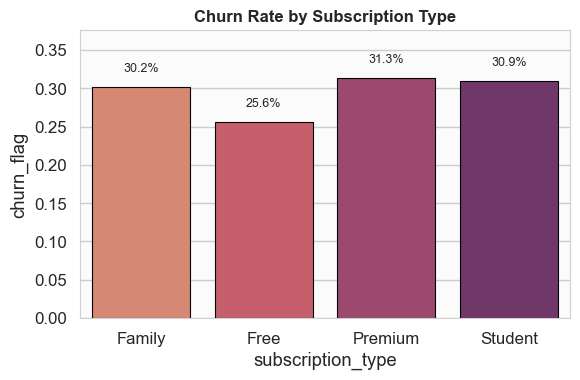

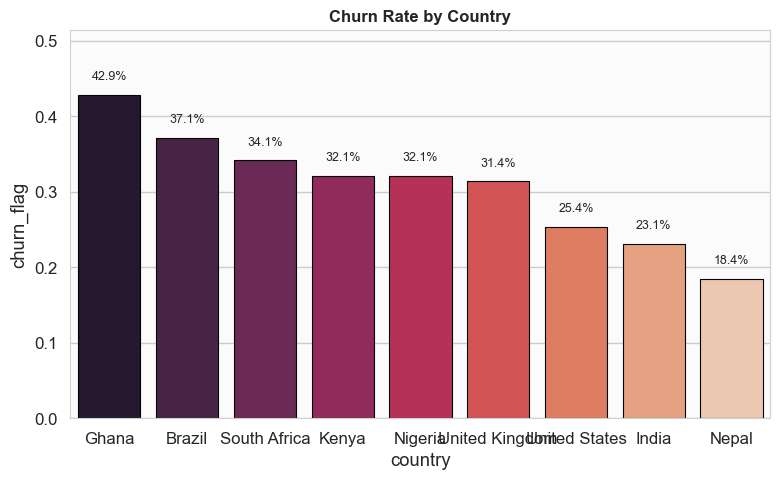

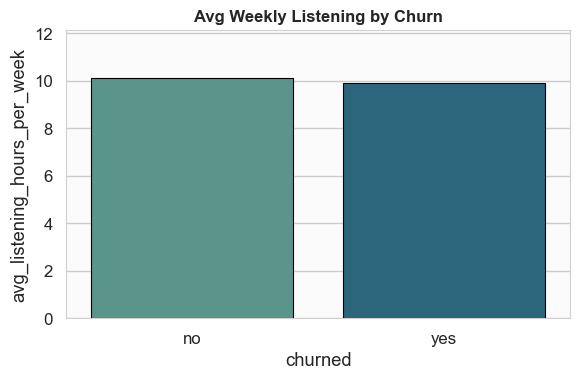

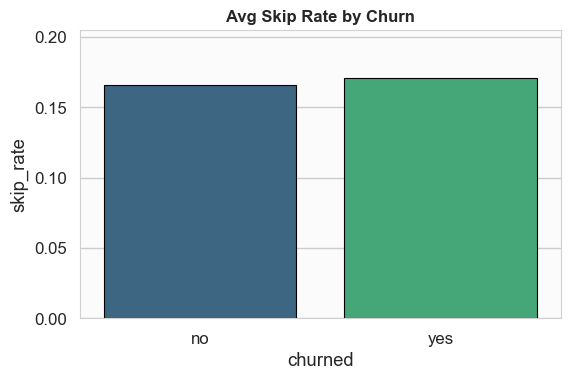

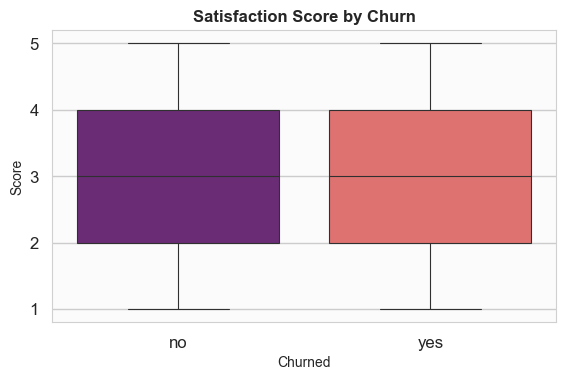

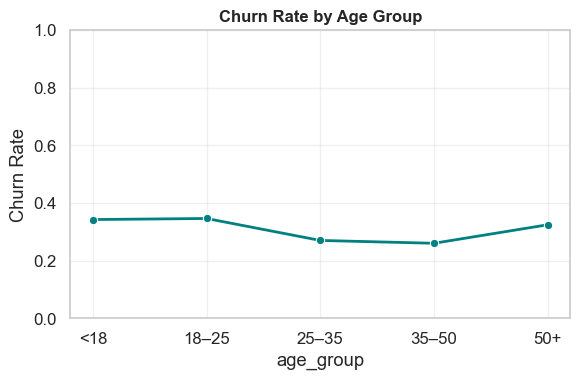

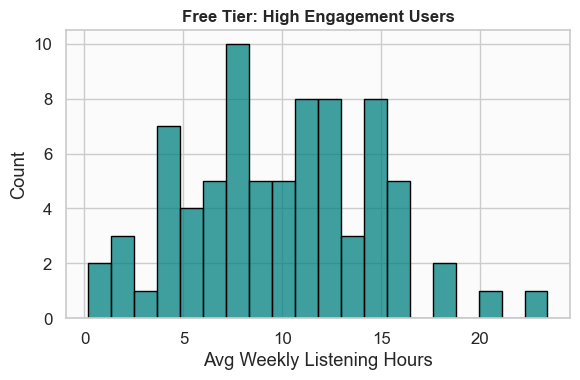

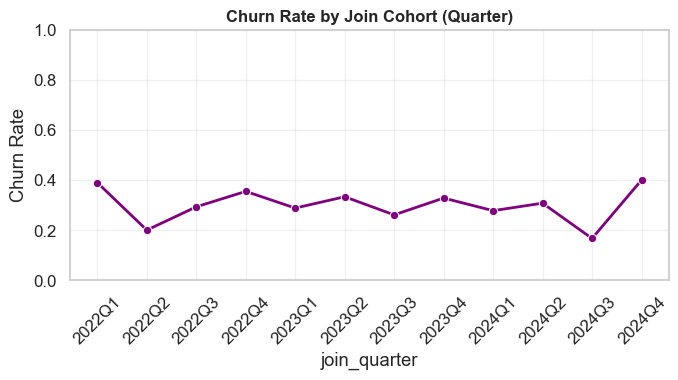

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned data
file = r"C:\Users\bista\Documents\Downloads\cleaned.csv"
df = pd.read_csv(file)

# Prepare churn flags
df['churned'] = df['churned'].str.lower()  # yes/no
df['churn_flag'] = df['churned'].map({'yes':1, 'no':0})

# Age groups & join quarter
df['age_group'] = pd.cut(df['age'], bins=[0,18,25,35,50,100], labels=['<18','18–25','25–35','35–50','50+'])
df['join_date'] = pd.to_datetime(df['join_date'], errors='coerce')
df['join_quarter'] = df['join_date'].dt.to_period('Q')

# Market type
developed_countries = ['United States', 'United Kingdom']
df['market_type'] = df['country'].apply(lambda x: 'Developed' if x in developed_countries else 'Emerging')

# ----------------------------
# Helper function for card-style barplots
# ----------------------------
def card_barplot(data, x, y, palette='crest', title='', figsize=(6,4), percent_labels=True):
    plt.figure(figsize=figsize)
    ax = sns.barplot(data=data, x=x, y=y, palette=palette, edgecolor='black', linewidth=0.8)
    plt.title(title, fontsize=12, weight='bold')
    
    # Card styling
    ax.set_facecolor('#fbfbfb')
    for spine in ax.spines.values():
        spine.set_linewidth(0.8)
        spine.set_edgecolor('#d0d0d0')
    
    # Percent labels
    if percent_labels:
        for p in ax.patches:
            val = p.get_height()
            ax.text(p.get_x()+p.get_width()/2, val + 0.02, f"{val*100:.1f}%", ha='center', fontsize=9)
    
    plt.ylim(0, data[y].max() * 1.2)
    plt.tight_layout()
    plt.show()


# ----------------------------
# 1️⃣ Churn Rate by Subscription Type
# ----------------------------
sub_churn = df.groupby('subscription_type')['churn_flag'].mean().reset_index()
card_barplot(sub_churn, 'subscription_type', 'churn_flag', palette='flare', title='Churn Rate by Subscription Type')

# ----------------------------
# 2️⃣ Churn Rate by Country
# ----------------------------
country_churn = df.groupby('country')['churn_flag'].mean().sort_values(ascending=False).reset_index()
card_barplot(country_churn, 'country', 'churn_flag', palette='rocket', title='Churn Rate by Country', figsize=(8,5))

# ----------------------------
# 3️⃣ Average Weekly Listening by Churn
# ----------------------------
listen_mean = df.groupby('churned')['avg_listening_hours_per_week'].mean().reset_index()
card_barplot(listen_mean, 'churned', 'avg_listening_hours_per_week', palette='crest', title='Avg Weekly Listening by Churn', percent_labels=False)

# ----------------------------
# 4️⃣ Skip Rate by Churn
# ----------------------------
skip_mean = df.groupby('churned')['skip_rate'].mean().reset_index()
card_barplot(skip_mean, 'churned', 'skip_rate', palette='viridis', title='Avg Skip Rate by Churn', percent_labels=False)

# ----------------------------
# 5️⃣ Satisfaction Score by Churn (Boxplot)
# ----------------------------
plt.figure(figsize=(6,4))
ax = sns.boxplot(data=df, x='churned', y='satisfaction_score', palette='magma', linewidth=0.8)
plt.title('Satisfaction Score by Churn', fontsize=12, weight='bold')
ax.set_facecolor('#fbfbfb')
for spine in ax.spines.values():
    spine.set_linewidth(0.8)
    spine.set_edgecolor('#d0d0d0')
plt.xlabel('Churned', fontsize=10)
plt.ylabel('Score', fontsize=10)
plt.tight_layout()
plt.show()

# ----------------------------
# 6️⃣ Churn Rate by Age Group (Smooth Line)
# ----------------------------
age_churn = df.groupby('age_group')['churn_flag'].mean().reset_index()
plt.figure(figsize=(6,4))
ax = sns.lineplot(data=age_churn, x='age_group', y='churn_flag', marker='o', linewidth=2, color='teal')
plt.title("Churn Rate by Age Group", fontsize=12, weight='bold')
plt.ylabel("Churn Rate")
plt.ylim(0,1)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------
# 7️⃣ Free Tier Engagement Histogram
# ----------------------------
free_users = df[df['subscription_type']=='Free']
plt.figure(figsize=(6,4))
ax = sns.histplot(free_users['avg_listening_hours_per_week'], bins=20, color='teal', edgecolor='black')
plt.title("Free Tier: High Engagement Users", fontsize=12, weight='bold')
plt.xlabel("Avg Weekly Listening Hours")
plt.ylabel("Count")
ax.set_facecolor('#fbfbfb')
plt.tight_layout()
plt.show()

# ----------------------------
# 8️⃣ Join Cohort: Churn Rate by Quarter
# ----------------------------
# Convert join_quarter to string for plotting
quarter_summary = df.groupby('join_quarter')['churn_flag'].mean().reset_index()
quarter_summary['join_quarter'] = quarter_summary['join_quarter'].astype(str)

plt.figure(figsize=(7,4))
ax = sns.lineplot(
    data=quarter_summary,
    x='join_quarter',
    y='churn_flag',
    marker='o',
    linewidth=2,
    color='purple'
)
plt.title("Churn Rate by Join Cohort (Quarter)", fontsize=12, weight='bold')
plt.ylabel("Churn Rate")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Logistic Regression Coefficients:
                         feature  coefficient
3                      skip_rate     0.512208
10               market_type_enc    -0.280473
6                     gender_enc    -0.112018
8                    country_enc    -0.067793
9                  age_group_enc     0.036732
4             satisfaction_score     0.035080
7          subscription_type_enc     0.019218
5              monthly_fee_clean    -0.013751
1   avg_listening_hours_per_week    -0.011922
0                            age    -0.004981
2             total_songs_played     0.000809
ROC-AUC Score: 0.554


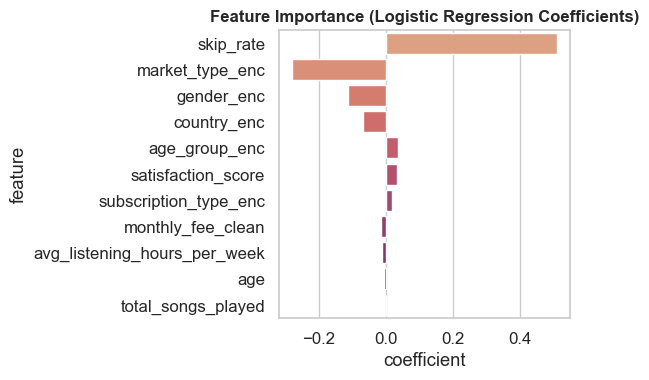

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# -----------------------------
# 1️⃣ Load cleaned dataset
# -----------------------------
file = r"C:\Users\bista\Documents\Downloads\cleaned.csv"
df = pd.read_csv(file)

# -----------------------------
# 2️⃣ Preprocessing
# -----------------------------
# Convert churn to numeric flag
df['churn_flag'] = df['churned'].str.lower().map({'yes':1, 'no':0})

# Fill missing numeric values
num_cols = ['age', 'avg_listening_hours_per_week', 'total_songs_played',
            'skip_rate', 'satisfaction_score', 'monthly_fee_clean']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(df[c].median())

# Age group
df['age_group'] = pd.cut(df['age'], bins=[0,18,25,35,50,100], labels=['<18','18–25','25–35','35–50','50+'])

# Market type
developed_countries = ['United States', 'United Kingdom']
df['market_type'] = df['country'].apply(lambda x: 'Developed' if x in developed_countries else 'Emerging')

# Encode categorical variables
cat_cols = ['gender', 'subscription_type', 'country', 'age_group', 'market_type']
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col+'_enc'] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le  # store encoder if needed later

# -----------------------------
# 3️⃣ Correlation / coefficients
# -----------------------------
# Select features
features = ['age', 'avg_listening_hours_per_week', 'total_songs_played',
            'skip_rate', 'satisfaction_score', 'monthly_fee_clean'] + [col+'_enc' for col in cat_cols]

X = df[features]
y = df['churn_flag']

# Logistic Regression to get coefficients
model = LogisticRegression(max_iter=500)
model.fit(X, y)

coefficients = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0]
}).sort_values(by='coefficient', key=abs, ascending=False)

print("Logistic Regression Coefficients:")
print(coefficients)

# ROC-AUC for reference
y_pred = model.predict_proba(X)[:,1]
auc = roc_auc_score(y, y_pred)
print(f"ROC-AUC Score: {auc:.3f}")

# -----------------------------
# 4️⃣ Improved plots: Dashboard style
# -----------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(6,4))
sns.barplot(data=coefficients, x='coefficient', y='feature', palette='flare')
plt.title("Feature Importance (Logistic Regression Coefficients)", fontsize=12, weight='bold')
plt.tight_layout()
plt.show()
